# Parametrization of axis-symmetric, complex bubbles shapes

Two bubbles are investigated:
- bubbles in aqueous sugar solutions (Bhaga & Weber 1981)
    - dimpled ellipsoidal $Eo=243$, $Mo=266$, $Ga^\prime=80$
    - skirted (smooth) $Eo = 339$, $Mo=43.1$, $Ga^\prime = 30.8$
    
The goal is to parametrize the bubbles shapes and then to export the shape as a geometry file that can be used by one of the standard OpenFOAM meshers. Bubbles with complex shapes (not star-shaped) cannot be described by a variable radius function $r=r(\varphi)$. Instead, the shape is approximated by two different functions, one for the *inner* and one for the *outer* contour (it will become clear later on what *inner* and *outer* means). The shape to approximate is given as a set of points coming from the piecewise linear interface recontruction of the flow solver (so-called PLIC planes). Specifically, the tersections of the PLIC plane with the underlying background mesh, referred to as *PLIC points* hereafter, will be used as training data.

Outline
1. for a given time instance, and load corresponding PLIC points
2. transform to polar coordinates and visualize the points
2. select some points on the innter contour of the bubble
3. approximate the inner contour using a MLP
4. select the remaining points of the inner contour using the approximation and a narrow band width
   and refine the approximation of the innter contour
5. selcet all points on the outer contour and create an approximation
6. use the networks to create a 2D STL file

## Load facets for given time instances

In [1]:
import helper_module as hm
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset
import numpy as np
from sklearn.neighbors import KernelDensity
import torch

%matplotlib inline

data_path = "../data/"
names = ["bhaga_02_l16", "bhaga_04_l16"]
times = [30, 20]
output_path = "../output/models"
!mkdir -p ../output/models
!mkdir -p ../output/STL

# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

cases = [data_path + name for name in names]

for i, case in enumerate(cases):
    print(i, case, times[i])

0 ../data/bhaga_02_l16 30
1 ../data/bhaga_04_l16 20


In [2]:
all_facets = {}
for i, case in enumerate(cases):
    log_path = case + "/log." + names[i] + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'x'])
    row = log.find_closest("time", times[i])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[names[i]] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)

Successfully read file ../data/bhaga_02_l16/log.bhaga_02_l16.csv
Successfully read file ../data/bhaga_02_l16/plic_clean/plic_062070.pkl
Successfully read file ../data/bhaga_04_l16/log.bhaga_04_l16.csv
Successfully read file ../data/bhaga_04_l16/plic_clean/plic_036380.pkl


## 2. Plot facets in polar coordinates

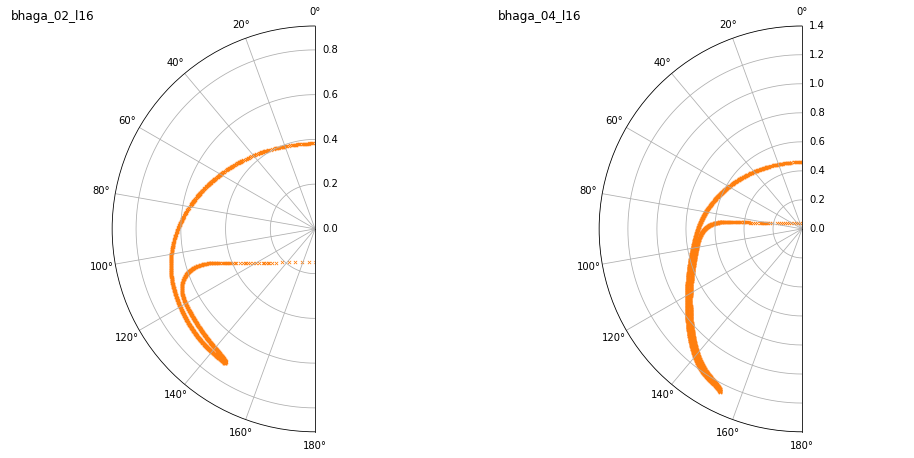

In [3]:
rc('text', usetex=False)
fig, axarr = plt.subplots(1, 2, figsize=(hm.figure_width, 8), subplot_kw=dict(projection='polar'))

for i, name in enumerate(names):
    rad, phi = all_facets[name].get_facets(polar=True)
    axarr[i].scatter(phi, rad, marker="x", color="C1", s=10, lw=0.5)
    axarr[i].set_theta_zero_location("N")
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].set_title(name, loc='left')

## 3. Find some points on the inner contour

In [4]:
def find_inner_shape(rad, phi, n_bins, r_max):
    '''Find the inner shape with the following steps:
       1. subdivide polar angle into bins
       2. find the point with the minimum radius in a bin
       3. drop the point if r > r_max
       
    Parameters
    ----------
    rad, phi - array-like: polar coordinates; expects that 0 <= phi <= pi/2
    n_bins - Integer   : number of bins for which to compute point averages
    r_max  - Float     : maximum radius of a point to consider
    
    Returns
    -------
    min_radius - array-like: radius of point on the inner contour
    min_phi - array-like: polar angle of points on the inner contour
    
    '''
    bin_length = 0.5*np.pi / n_bins
    bin_centers = np.arange(0.5*bin_length, 0.5*np.pi, bin_length)
    phi_min = np.zeros(n_bins)
    radius_min = np.ones(n_bins) * r_max
    for p, r in zip(phi, rad):
        for j, b in enumerate(bin_centers):
            if (p <= b+0.5*bin_length) and (p >= b-0.5*bin_length):
                if (r < radius_min[j]) and (r < r_max):
                    radius_min[j] = r
                    phi_min[j] = p
                break
    min_radius = np.asarray([r for r in radius_min if r < r_max])
    min_phi = np.asarray([phi_min[i] for i in range(n_bins) if radius_min[i] < r_max])
    return min_radius, min_phi

Text(0.5,0,'$\\varphi$')

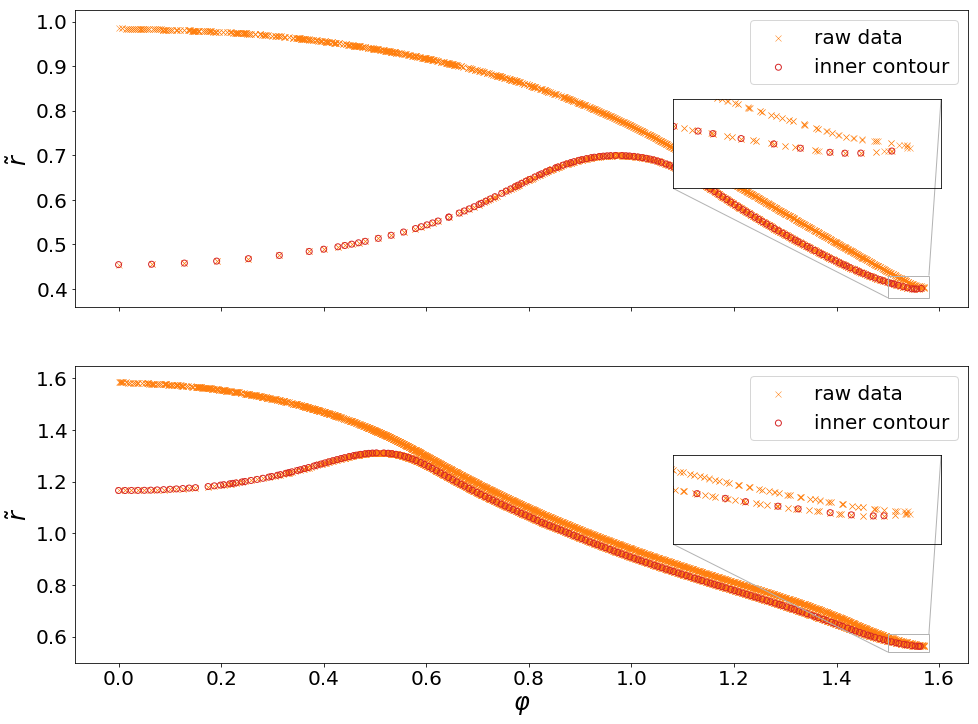

In [5]:
rc('text', usetex=False)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 12), sharex=True)

n_bins = [200, 200] # devide polar angle in n_bins
r_max = [0.8, 1.4]  # do consider points with r > r_max

# plotting
x_lim =[[1.5, 1.58], [1.5, 1.58]]
y_lim =[[0.38, 0.43], [0.54, 0.61]]

for i, name in enumerate(names):
    px, py = all_facets[name].get_facets(polar=False)
    rad, phi = hm.transform_polar_2D(px, py+np.absolute(np.min(py)))
    rad_in, phi_in = find_inner_shape(rad, phi, n_bins[i], r_max[i])
    axarr[i].scatter(phi, rad, marker="x", c="C1", lw=0.5, label="raw data")
    axarr[i].scatter(phi_in, rad_in, marker="o", facecolors='none', edgecolors='C3', label="inner contour")
    zoom = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=x_lim[i], ylim=y_lim[i])
    zoom.scatter(phi, rad, marker="x", c="C1", lw=0.5)
    zoom.scatter(phi_in, rad_in, marker="o", facecolors='none', edgecolors='C3')
    ip = InsetPosition(axarr[i], [0.67, 0.4, 0.3, 0.3])
    zoom.set_axes_locator(ip)
    mark_inset(axarr[i], zoom, loc1=3, loc2=1, fc="none", ec='0.7')
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

## 4. Approximate inner contour

In [6]:
# TODO: these two functions are simply copied from the notebook for simples shapes, refactor!
def training_loop(model, path, x_train, y_train, y_weight, epochs, l_rate):
    """Optimize the weights of a given MLP.
    
    Parameters
    ----------
    model - SimpleMLP : model to optimize
    path - String : path to save best model weights
    x_train - array-like : feature vector of dimension [n_samples, n_features]
    y_train - array-like : label vector of dimension [n_samples, n_labels]
    y_weight - array-like : vector to put more weight on specific points in the training set; dimension [n_samples]
    epochs - Integer : number of epochs to train
    l_rate - Float : learning rate
    
    Returns
    -------
    history - List : loss developments over epochs
    model - SimpleMLP : opimized model in evaluation mode
    
    """
    if y_weight is None: y_weight = np.ones(x_train.shape[0])
    x_tensor = torch.from_numpy(x_train.astype(np.float64)).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y_train.astype(np.float64))
    y_weight_tensor = torch.from_numpy(y_weight.astype(np.float64))
    zero = torch.zeros(y_tensor.shape[0])
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)

    best_loss = 1.0E5
    train_loss = []

    for e in range(1, epochs+1):
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        diff = (output.squeeze(dim=1) - y_tensor) * y_weight_tensor
        loss = criterion(diff, zero)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), path)
    return model.eval(), np.asarray(train_loss)

# convinience function for saving plots as png and pdf
def savefig(name):
    path = "../output/"
    plt.savefig(path + name + ".png", bbox_inches="tight")
    plt.savefig(path + name + ".pdf", bbox_inches="tight")

Minimal loss:  2.69937741633e-06
Minimal loss:  4.46655544634e-06


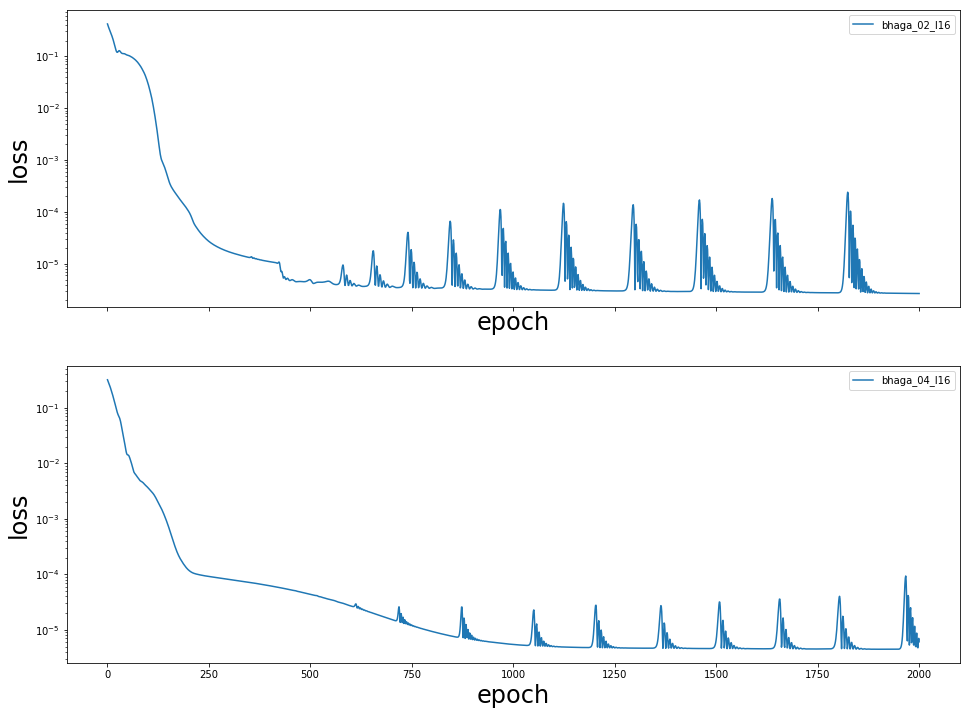

In [7]:
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 12), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.relu,
    "batch_norm" : False
}

epochs = 2000
for i, name in enumerate(names):
    model = hm.SimpleMLP(**model_dict)
    px, py = all_facets[name].get_facets(polar=False)
    rad, phi = hm.transform_polar_2D(px, py+np.absolute(np.min(py)))
    rad_in, phi_in = find_inner_shape(rad, phi, n_bins[i], r_max[i])
    rad_norm = (rad_in - np.min(rad_in)) / (np.max(rad_in) - np.min(rad_in))
    model_path = output_path + "/" + name + "_inner_first.pt"
    model = hm.SimpleMLP(**model_dict)
    model, losses = training_loop(model, model_path, phi_in, rad_norm, None, epochs, 0.001)
    print("Minimal loss: ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name)
    axarr[i].set_xlabel("epoch", fontsize=hm.fontsize_label)
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()

Text(0.5,0,'$\\varphi$')

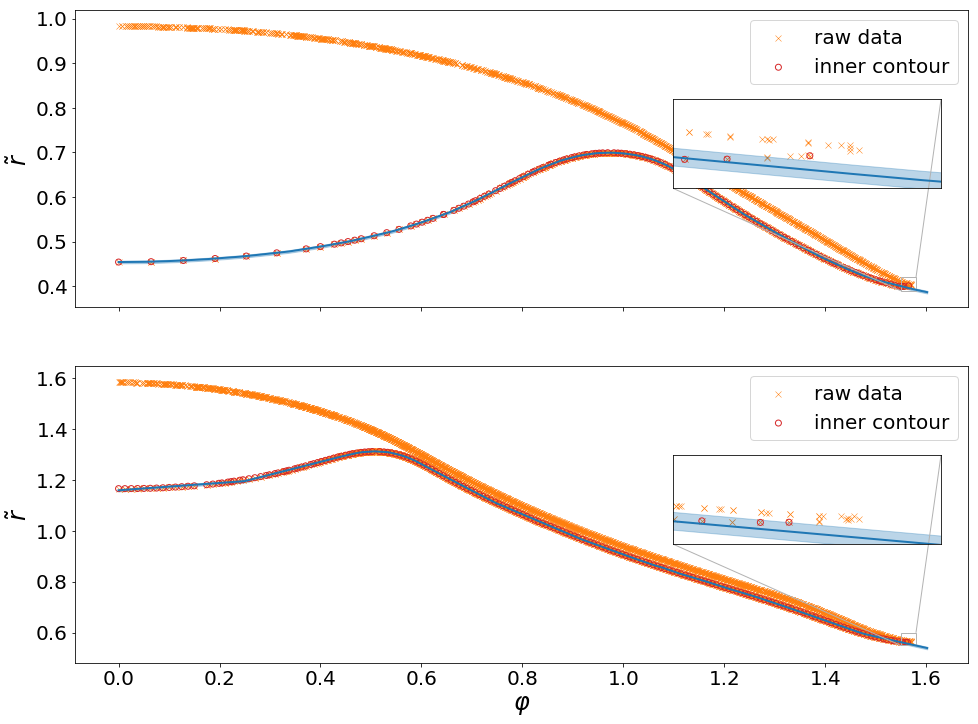

In [8]:
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 12), sharex=True)

n_bins = [200, 200] # devide polar angle in n_bins
r_max = [0.8, 1.4]  # do consider points with r > r_max

# plotting
x_lim =[[1.55, 1.58], [1.55, 1.58]]
y_lim =[[0.39, 0.42], [0.55, 0.60]]
phi_eval = torch.from_numpy(np.linspace(0.0, 0.51*np.pi, 200)).unsqueeze_(-1)
band = [0.003, 0.005]

for i, name in enumerate(names):
    px, py = all_facets[name].get_facets(polar=False)
    rad, phi = hm.transform_polar_2D(px, py+np.absolute(np.min(py)))
    rad_in, phi_in = find_inner_shape(rad, phi, n_bins[i], r_max[i])
    model_path = output_path + "/" + name + "_inner_first.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    rad_eval = rad_eval * (np.max(rad_in) - np.min(rad_in)) + np.min(rad_in)
    
    axarr[i].fill_between(phi_eval.squeeze(), rad_eval-band[i], rad_eval+band[i], color="C0", alpha=0.3)
    axarr[i].scatter(phi, rad, marker="x", c="C1", lw=0.5, label="raw data")
    axarr[i].scatter(phi_in, rad_in, marker="o", facecolors='none', edgecolors='C3', label="inner contour")
    axarr[i].plot(phi_eval, rad_eval, c="C0", lw=2)
    zoom = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=x_lim[i], ylim=y_lim[i])
    zoom.scatter(phi, rad, marker="x", c="C1", lw=0.5)
    
    zoom.fill_between(phi_eval.squeeze(), rad_eval-band[i], rad_eval+band[i], color="C0", alpha=0.3)
    zoom.plot(phi_eval, rad_eval, c="C0", lw=2)
    zoom.scatter(phi_in, rad_in, marker="o", facecolors='none', edgecolors='C3')
    ip = InsetPosition(axarr[i], [0.67, 0.4, 0.3, 0.3])
    zoom.set_axes_locator(ip)
    mark_inset(axarr[i], zoom, loc1=3, loc2=1, fc="none", ec='0.7')
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

## Select points in the narrow band and split training data

In [9]:
phi_inner = {}
phi_outer = {}
rad_inner = {}
rad_outer = {}

for i, name in enumerate(names):
    px, py = all_facets[name].get_facets(polar=False)
    rad, phi = hm.transform_polar_2D(px, py+np.absolute(np.min(py)))
    rad_in, phi_in = find_inner_shape(rad, phi, n_bins[i], r_max[i])
    model_path = output_path + "/" + name + "_inner_first.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    phi_eval = torch.from_numpy(phi.astype(np.float64)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    rad_eval = rad_eval * (np.max(rad_in) - np.min(rad_in)) + np.min(rad_in)
    # select points in the narrow band
    dist = rad - rad_eval
    rad_band = np.asarray([rad[j] for j in range(len(rad)) if dist[j] <=  band[i]])
    phi_band = np.asarray([phi[j] for j in range(len(rad)) if dist[j] <=  band[i]])
    phi_inner[name] = np.append(phi_in, phi_band, axis=0)
    rad_inner[name] = np.append(rad_in, rad_band, axis=0)
    rad_band = np.asarray([rad[j] for j in range(len(rad)) if dist[j] >  band[i]])
    phi_band = np.asarray([phi[j] for j in range(len(rad)) if dist[j] >  band[i]])
    phi_outer[name] = phi_band
    rad_outer[name] = rad_band
    print("Case: ", name)
    print("Selected {:4d} points on the inner and {:4d} points on the outer contour.".format(
        phi_inner[name].shape[0], phi_outer[name].shape[0]))

Case:  bhaga_02_l16
Selected 1058 points on the inner and 1533 points on the outer contour.
Case:  bhaga_04_l16
Selected 2030 points on the inner and 2368 points on the outer contour.


Text(0.5,0,'$\\varphi$')

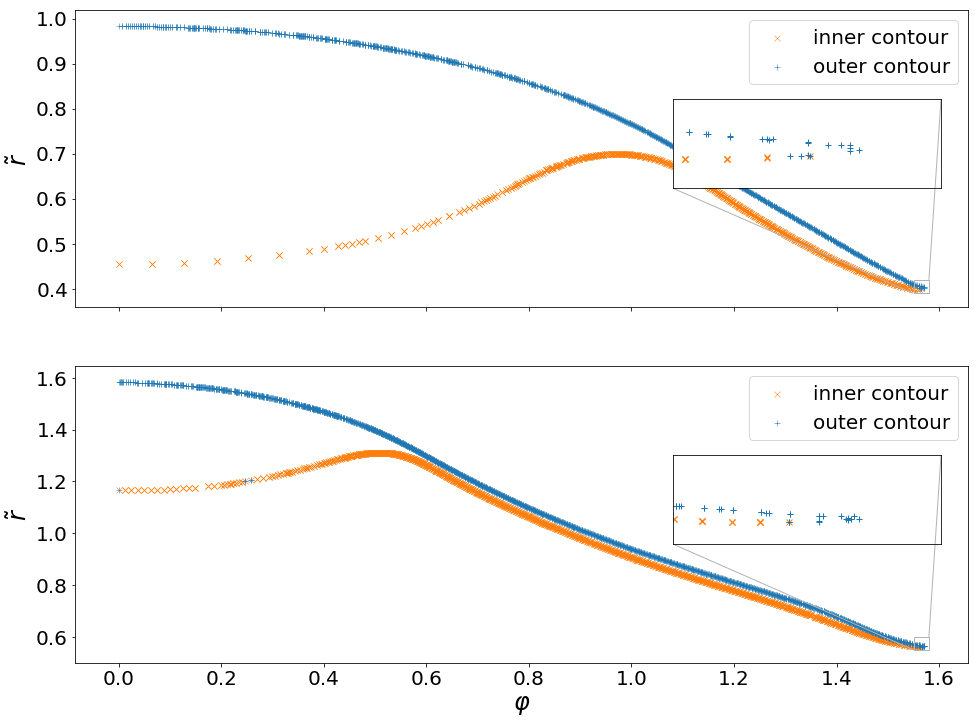

In [10]:
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 12), sharex=True)

for i, name in enumerate(names):
    axarr[i].scatter(phi_inner[name], rad_inner[name], marker="x", c="C1", lw=0.5, label="inner contour")
    axarr[i].scatter(phi_outer[name], rad_outer[name], marker="+", c="C0", lw=0.5, label="outer contour")
    zoom = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=x_lim[i], ylim=y_lim[i])
    zoom.scatter(phi_inner[name], rad_inner[name], marker="x", c="C1", lw=1.0)
    zoom.scatter(phi_outer[name], rad_outer[name], marker="+", c="C0", lw=1.0)
    ip = InsetPosition(axarr[i], [0.67, 0.4, 0.3, 0.3])
    zoom.set_axes_locator(ip)
    mark_inset(axarr[i], zoom, loc1=3, loc2=1, fc="none", ec='0.7')
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

## Visualize data density and weighting

In [11]:
def density_based_weighting(density, alpha):
    return alpha + (1.0 - alpha) * density

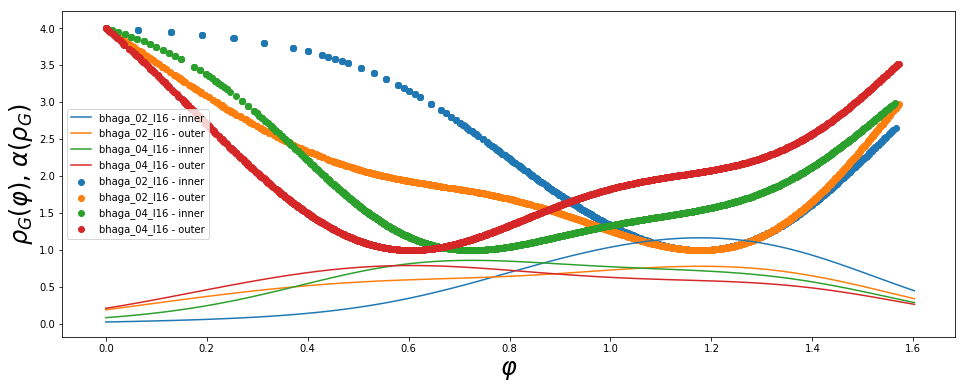

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

densities_01 = {}

phi_plot = np.linspace(0.0, 0.51*np.pi, 100)
for i, name in enumerate(names):
    phi_in = phi_inner[name]
    phi_out = phi_outer[name]
    for cont, phi in zip(["inner", "outer"], [phi_in, phi_out]):
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(phi[:,np.newaxis])
        log_dens = kde.score_samples(phi[:,np.newaxis])
        density = np.exp(log_dens)
        densities_01[name + "_" + cont] = (density - np.min(density)) / (np.max(density) - np.min(density))
        log_dens = kde.score_samples(phi_plot[:,np.newaxis])
        ax.plot(phi_plot, np.exp(log_dens), label=name + " - " + cont)
        ax.scatter(phi, density_based_weighting(densities_01[name+ "_" + cont], 4), label=name + " - " + cont)
ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\rho_G (\varphi)$, $\alpha (\rho_G)$", fontsize=hm.fontsize_label)
ax.legend()

## Approximate inner and outer contour

Minimal loss:  4.2049497239e-06
Minimal loss:  1.69522094145e-06
Minimal loss:  2.33917176012e-06
Minimal loss:  0.00301856091763


Text(0.5,0,'epoch')

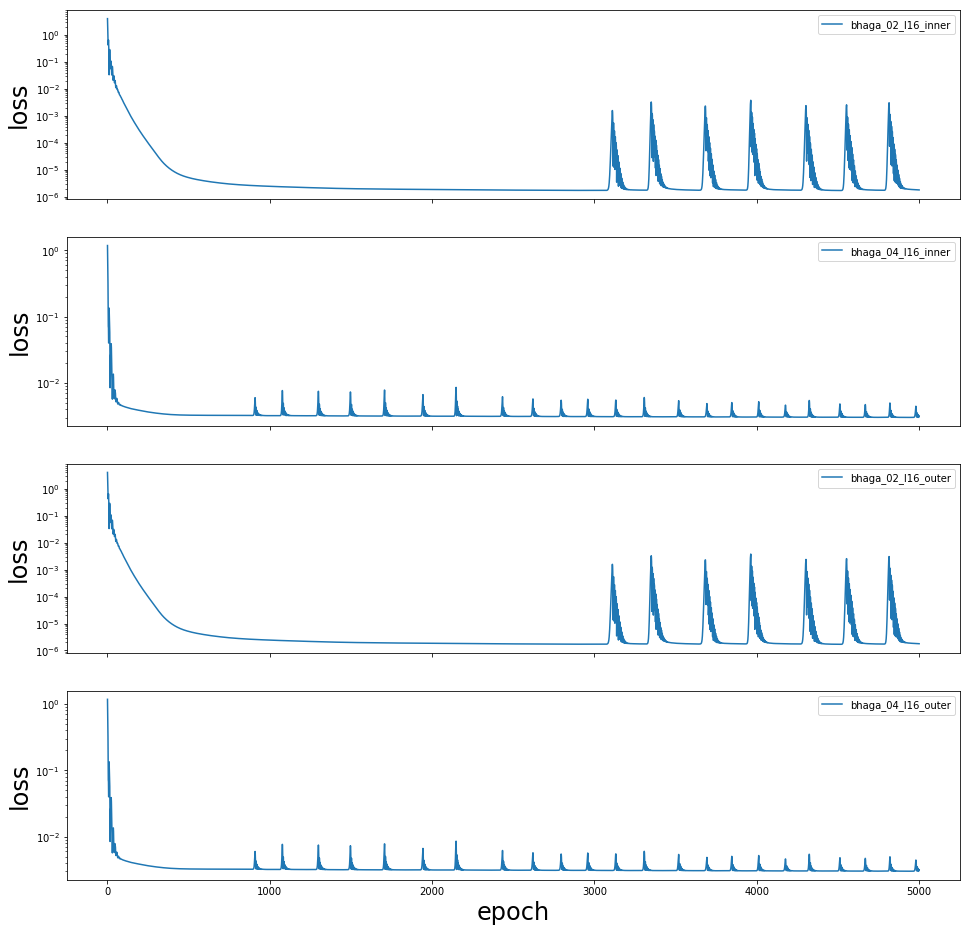

In [13]:
fig, axarr = plt.subplots(4, 1, figsize=(hm.figure_width, 16), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 60,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

epochs = 5000
for i, name in enumerate(names):
    phi_in = phi_inner[name]
    rad_in = rad_inner[name]
    rad_norm = (rad_in - np.min(rad_in)) / (np.max(rad_in) - np.min(rad_in))
    model_path = output_path + "/" + name + "_inner_final.pt"
    model = hm.SimpleMLP(**model_dict)
    alpha_in = density_based_weighting(densities_01[name + "_inner"], 5)
    model, losses = training_loop(model, model_path, phi_in, rad_norm, alpha_in, epochs, 0.001)
    print("Minimal loss: ", np.min(losses))
    phi_out = phi_outer[name]
    rad_out = rad_outer[name]
    rad_norm = (rad_out - np.min(rad_out)) / (np.max(rad_out) - np.min(rad_out))
    model_path = output_path + "/" + name + "_outer_final.pt"
    model = hm.SimpleMLP(**model_dict)
    alpha_out = density_based_weighting(densities_01[name + "_outer"], 5)
    model, losses = training_loop(model, model_path, phi_out, rad_norm, alpha_out, epochs, 0.001)
    print("Minimal loss: ", np.min(losses))
    axarr[i].plot(range(1, epochs+1), losses, label=name + "_inner")
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()
    axarr[i+2].plot(range(1, epochs+1), losses, label=name + "_outer")
    axarr[i+2].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i+2].set_yscale('log')
    axarr[i+2].legend()
axarr[-1].set_xlabel("epoch", fontsize=hm.fontsize_label)

Text(0.5,0,'$\\varphi$')

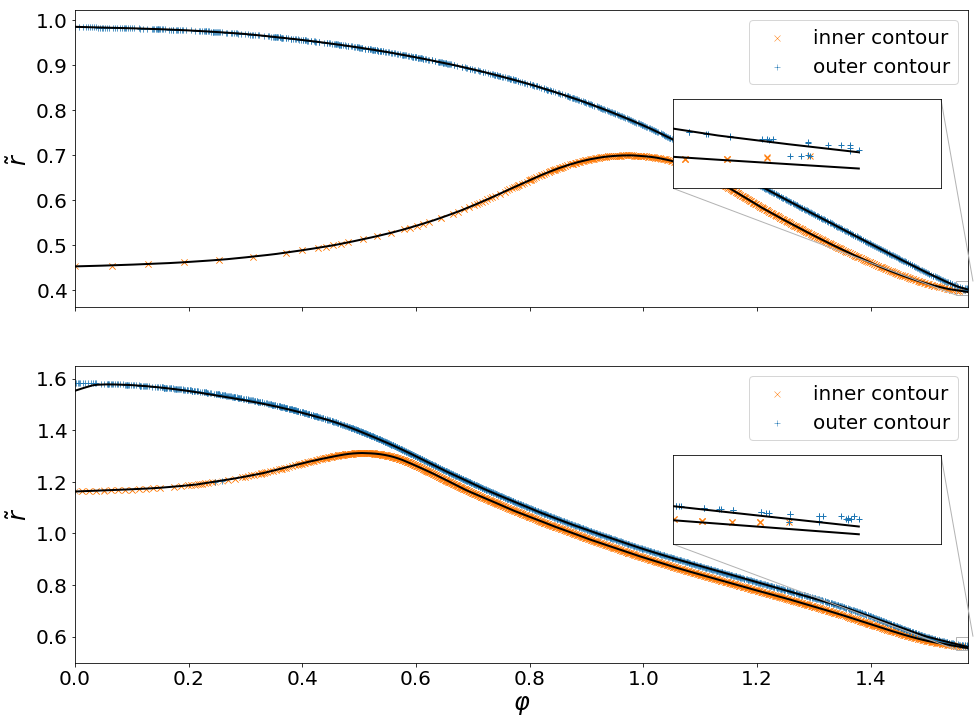

In [14]:
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 12), sharex=True)

phi_eval = torch.from_numpy(np.linspace(0.0, 0.5*np.pi, 200)).unsqueeze_(-1)

for i, name in enumerate(names):
    model_path = output_path + "/" + name + "_inner_final.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model_in = model.forward(phi_eval).detach().squeeze().numpy()
    model_in = model_in * (np.max(rad_inner[name]) - np.min(rad_inner[name])) + np.min(rad_inner[name])
    model_path = output_path + "/" + name + "_outer_final.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model_out = model.forward(phi_eval).detach().squeeze().numpy()
    model_out = model_out * (np.max(rad_outer[name]) - np.min(rad_outer[name])) + np.min(rad_outer[name])
    axarr[i].plot(phi_eval, model_in, c="k", lw=2)
    axarr[i].plot(phi_eval, model_out, c="k", lw=2)
    axarr[i].scatter(phi_inner[name], rad_inner[name], marker="x", c="C1", lw=0.5, label="inner contour")
    axarr[i].scatter(phi_outer[name], rad_outer[name], marker="+", c="C0", lw=0.5, label="outer contour")
    # zoom
    zoom = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=x_lim[i], ylim=y_lim[i])
    zoom.plot(phi_eval, model_in, c="k", lw=2)
    zoom.plot(phi_eval, model_out, c="k", lw=2)
    zoom.scatter(phi_inner[name], rad_inner[name], marker="x", c="C1", lw=1.0)
    zoom.scatter(phi_outer[name], rad_outer[name], marker="+", c="C0", lw=1.0)
    ip = InsetPosition(axarr[i], [0.67, 0.4, 0.3, 0.3])
    zoom.set_axes_locator(ip)
    mark_inset(axarr[i], zoom, loc1=3, loc2=1, fc="none", ec='0.7')
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
    axarr[i].set_xlim(0, 0.5*np.pi)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

## 7. Combining inner and outer contour to create a 2D .stl file

In [15]:
# helper functions and structure
class Facet():
    def __init__(self, p1, p2, p3):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        
    def print_normal(self):
        normal = np.cross(self.p3-self.p1, self.p2-self.p1)
        normal = normal / np.linalg.norm(normal)
        return self.vec2str(normal)
        
    def print_points(self, pref):
        return pref + self.vec2str(self.p1) + '\n' + pref + self.vec2str(self.p2) + '\n' + pref + self.vec2str(self.p3) + '\n'
    
    @staticmethod
    def vec2str(vec):
        return str(vec[0]) + ' ' + str(vec[1]) + ' ' + str(vec[2])
    

def cartesian_coordinates(phi, radius):
    x = np.sin(phi) * radius
    y = np.cos(phi) * radius
    return x, y


def write_stl(path, name, facets):
    stl_file = open(path, 'w')
    stl_file.write("solid " + name + '\n')
    for facet in facets:
        stl_file.write("facet normal " + facet.print_normal() + "\n")
        stl_file.write("    outer loop\n")
        pref = ' ' * 8 + "vertex "
        stl_file.write(facet.print_points(pref))
        stl_file.write("    endloop\n")
        stl_file.write("endfacet\n")
    
    stl_file.write("endsolid " + name)
    stl_file.close()

In [16]:
height = 1.0

for case in ["bhaga_02_l16", "bhaga_04_l16"]:
    px, py = shapes[case]
    offset = abs(np.amin(px))
    inner.load_state_dict(torch.load("./models/" + case + "_inner_full.pt"))
    outer.load_state_dict(torch.load("./models/" + case + "_outer.pt"))
    inner_radius = inner.forward(phi_tensor).detach().squeeze().numpy()
    outer_radius = outer.forward(phi_tensor).detach().squeeze().numpy()
    
    full_phi = np.append(phi, phi[::-1], axis=0)
    full_radius = np.append(outer_radius, inner_radius[::-1], axis=0)
    x, y = cartesian_coordinates(full_phi, full_radius)
    y -= offset
    facet_list = []
    for i in range(len(x)-1):
        # upper triangle
        facet_list.append(Facet(np.asarray([x[i], y[i], 0.0]),
                                np.asarray([x[i+1], y[i+1], height]),
                                np.asarray([x[i], y[i], height]))
                        )
        # lower triangle
        facet_list.append(Facet(np.asarray([x[i], y[i], 0.0]),
                                np.asarray([x[i+1], y[i+1], 0.0]),
                                np.asarray([x[i+1], y[i+1], height]))
                         )
    #path = "./" + case + ".stl"
    #write_stl(path, case, facet_list)

NameError: name 'shapes' is not defined